In [13]:
import sys, os; sys.path.append(os.path.abspath(".."))
import pandas as pd
import numpy as np
import statsmodels.api as sm

from src.io_utils import load_parquet
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# Load prepared data

X_final = load_parquet("../data/interim/X_final.parquet")
transformed_df = load_parquet("../data/interim/transformed_df.parquet")
y = load_parquet("../data/interim/target.parquet")["SalePrice"]

# your existing linear evaluation/tuning helpers can be reused here
# (paste your cv_eval_models + tune/eval code or import your module if you wrapped it)

In [14]:
def univariate_linreg_statsmodels(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    log_target: bool = False
) -> pd.DataFrame:
    """
    Runs separate OLS for each single feature vs. y.
    If log_target=True, fits on log1p(y) and reports RMSE in dollars (back-transformed).
    Coefficients and intercept are reported in the model's native space
    (log-price when log_target=True; raw dollars otherwise).
    """
    rows = []
    y_array = np.asarray(y)
    y_trainable = np.log1p(y_array) if log_target else y_array  # training target

    for col in X.columns:
        x = X[[col]]
        if np.allclose(x.values.std(), 0):
            # constant feature: skip fit/metrics
            rows.append({
                "feature": col,
                "r2": np.nan,
                "rmse": np.nan,
                "coef": 0.0,
                "intercept": float(np.mean(y_trainable)),
                "p_value": np.nan,
                "coef_ci_low": np.nan,
                "coef_ci_high": np.nan,
                "fitted_on_log_target": bool(log_target)
            })
            continue

        Xc = sm.add_constant(x, has_constant="add")
        model = sm.OLS(y_trainable, Xc).fit()

        # Predictions in training space
        y_pred_train_space = model.predict(Xc)

        # RMSE: report in dollars if we trained in log space
        if log_target:
            y_pred_dollars = np.expm1(y_pred_train_space)
            rmse = float(np.sqrt(((y_array - y_pred_dollars) ** 2).mean()))
        else:
            rmse = float(np.sqrt(((y_array - y_pred_train_space) ** 2).mean()))

        coef = float(model.params[col])
        ci_low, ci_high = model.conf_int().loc[col].tolist()
        p = float(model.pvalues[col])

        rows.append({
            "feature": col,
            "r2": float(model.rsquared),
            "rmse": rmse,
            "coef": coef,
            "intercept": float(model.params["const"]),
            "p_value": p,
            "coef_ci_low": float(ci_low),
            "coef_ci_high": float(ci_high),
            "fitted_on_log_target": bool(log_target)
        })

    out = pd.DataFrame(rows).sort_values("r2", ascending=False).reset_index(drop=True)
    return out

In [15]:
results_df = univariate_linreg_statsmodels(X_final, y, log_target=True)

results_df

,feature,r2,rmse,coef,intercept,p_value,coef_ci_low,coef_ci_high,fitted_on_log_target
0,OverallQual,6.657922e-01,42826.954278,0.315983,12.013480,0.000000,0.307337,0.324629,True
1,TotalSF,6.638459e-01,43895.469032,0.315521,12.013480,0.000000,0.306850,0.324192,True
2,GrLivArea,5.329337e-01,53117.216109,0.282703,12.013480,0.000000,0.272482,0.292924,True
3,TotalBaths,4.488665e-01,60769.294082,0.259450,12.013480,0.000000,0.248347,0.270553,True
4,ExterQual,4.436785e-01,54418.774564,0.460922,10.920666,0.000000,0.440989,0.480855,True
...,...,...,...,...,...,...,...,...,...
262,LotConfig_FR2,5.934953e-07,76150.575135,-0.001742,12.013533,0.968801,-0.089086,0.085602,True
263,RoofStyle_Mansard,3.421496e-07,76151.250332,0.003645,12.013466,0.976309,-0.237045,0.244336,True
264,Exterior1st_Plywood,7.390638e-08,76151.740968,0.000399,12.013450,0.988988,-0.056315,0.057113,True
265,HouseStyle_2.5Unf,2.132083e-09,76151.254731,-0.000194,12.013482,0.998130,-0.162848,0.162459,True


<Axes: xlabel='TotalBaths'>

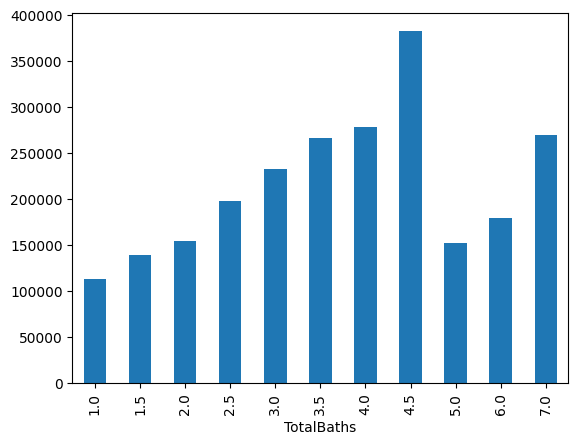

In [17]:
pd.concat([transformed_df, y], axis = 1).groupby(results_df.feature[3])['SalePrice'].mean().plot(kind="bar")